# Libraries Used

In [15]:
import numpy as np
import pandas as pd
import pathlib, glob
import warnings

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf

from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Data Preprocessing

In [3]:
data_dir = "PV"

In [4]:
data_dir = pathlib.Path(data_dir)
folder = list(data_dir.glob('*'))
print('Folder Structure:')
for f in folder:
    print(f)

Folder Structure:
PV\2_Feb_SFV_63176617_2016.xlsx
PV\3_Mar_SFV_63176617_2016.xlsx
PV\4_Apr_SFV_63176617_2016.xlsx
PV\5_May_SFV_63176617_2016.xlsx
PV\6_Jun_SFV_63176617_2016.xlsx
PV\7_Jul_SFV_63176617_2016.xlsx


In [6]:
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
datosPV = pd.DataFrame()
for f in sorted(glob.glob(str(data_dir)+"/*.xlsx")):
  df = pd.read_excel(f, header=0)
  datosPV = pd.concat([datosPV,df], axis=0, ignore_index=True)
datosPV = datosPV.dropna(axis=1)
datosPV = datosPV.drop(range(0, 960, 1),axis=0).reset_index(drop=True)
datosPV = datosPV.drop(labels=['MEDIDOR','KWHR','KVARHD','FECHA','INTERVALO'],axis=1)
rng = pd.date_range(start = '2016-02-11 00:00', end ='2016-07-31 23:45', freq='15min')
datosPV = datosPV.set_index(rng)
datosPV = datosPV.asfreq('15min')
datosPV.head(5)

,KWHD
2016-02-11 00:00:00,0.0
2016-02-11 00:15:00,0.0
2016-02-11 00:30:00,0.0
2016-02-11 00:45:00,0.0
2016-02-11 01:00:00,0.0


In [7]:
fin_train = '2016-06-10 09:45:00'
fin_validacion = '2016-07-14 19:15:00'

datosPV_train = datosPV.loc[: fin_train, :]
datosPV_val = datosPV.loc[fin_train:fin_validacion, :]
datosPV_test = datosPV.loc[fin_validacion:, :]

train_size = datosPV_train.shape[0]
val_size = datosPV_val.shape[0]
test_size = datosPV_test.shape[0]

print(f"Fechas train      : {datosPV_train.index.min()} --- {datosPV_train.index.max()}")
print(f"Fechas validacion : {datosPV_val.index.min()} --- {datosPV_val.index.max()}")
print(f"Fechas test       : {datosPV_test.index.min()} --- {datosPV_test.index.max()}")

Fechas train      : 2016-02-11 00:00:00 --- 2016-06-10 09:45:00
Fechas validacion : 2016-06-10 09:45:00 --- 2016-07-14 19:15:00
Fechas test       : 2016-07-14 19:15:00 --- 2016-07-31 23:45:00


In [8]:
datosPV['hour_day'] = datosPV.index.hour
datosPV['month'] = datosPV.index.month

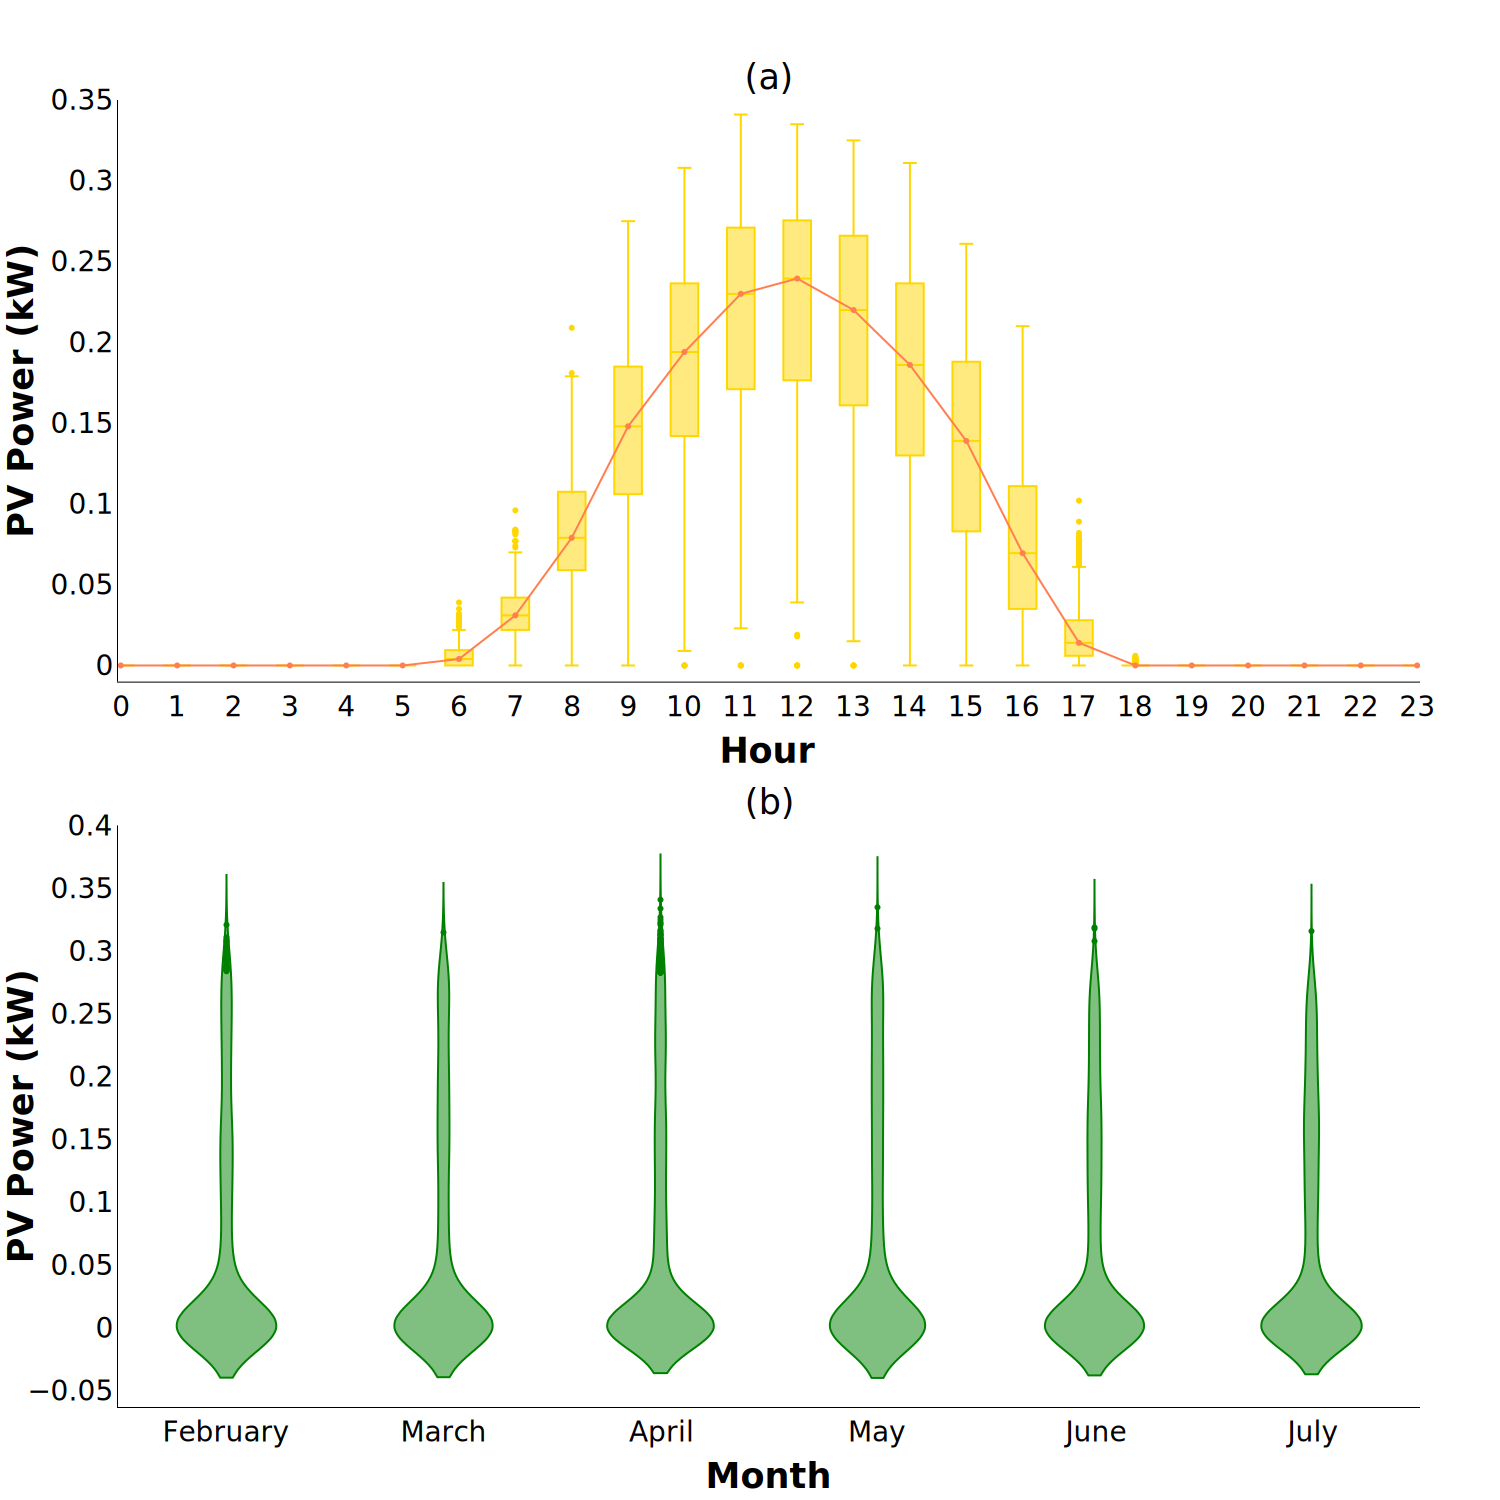

In [11]:
figPVEDA = make_subplots(rows=2, cols=1, vertical_spacing = 0.11, subplot_titles=['(a)','(b)'])

figPVEDA.append_trace(go.Box(y=datosPV.KWHD,x=datosPV.hour_day,marker_color='gold'),row=1, col=1)
figPVEDA.append_trace(go.Scatter(y=datosPV.groupby('hour_day')['KWHD'].median(),mode='lines+markers',line=dict(color='coral')),row=1, col=1)

figPVEDA.append_trace(go.Violin(y=datosPV.KWHD,x=datosPV.index.month_name(),marker_color='green'),row=2, col=1)


figPVEDA.update_layout(title='',
                      #paper_bgcolor='rgba(0,0,0,0)',
                      plot_bgcolor='rgba(0,0,0,0)',
                      width=1500,height=1500,
                      yaxis=dict(color="black"),
                      xaxis=dict(color="black",tickmode='linear',tick0=0,dtick=1,tickformat = '.0f'),
                      font=dict(family="Fira Sans, Condensed", color='black'),
                      showlegend=False)

figPVEDA.update_xaxes(range=['-0.05','23.05'],showline=True, linewidth=1, linecolor='black', gridcolor=None, mirror=False, title_text='<b>Hour </b>', titlefont_size=35, tickfont_size=28, tickangle=0, row=1,col=1)
figPVEDA.update_xaxes(showline=True, linewidth=1, linecolor='black', gridcolor=None, mirror=False, title_text='<b>Month </b>', titlefont_size=35, tickfont_size=28, tickangle=0, row=2,col=1)
figPVEDA.update_yaxes(range=['-0.01','0.35'],showline=True, linewidth=1, gridcolor=None, linecolor='black', mirror=False, title_text='<b>PV Power (kW)</b>', titlefont_size=35, tickfont_size=28, row=1,col=1)
figPVEDA.update_yaxes(showline=True, linewidth=1, gridcolor=None, linecolor='black', mirror=False, title_text='<b>PV Power (kW)</b>', titlefont_size=35, tickfont_size=28, row=2,col=1)
figPVEDA.update_annotations(font=dict(size=35))
figPVEDA.show("svg")

In [13]:
def create_corr_plot(series, plot_pacf=True, lags=40, alpha=0.05):
    corr_array = pacf(series.dropna(), alpha=0.05) if plot_pacf else acf(series.dropna(), alpha=alpha, fft=False, nlags=lags)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]
    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f')
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230, 0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,lags+2])
    fig.update_yaxes(zerolinecolor='#000000')

    title='' if plot_pacf else ''

    fig.update_layout(title=title,
                      #paper_bgcolor='rgba(0,0,0,0)',
                      plot_bgcolor='rgba(0,0,0,0)',
                      width=1500,height=800,
                      yaxis=dict(color="black"),
                      xaxis=dict(color="black"),
                      font=dict(family="Fira Sans, Condensed", color='black'),
                      showlegend=False)

    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=False, title_text='<b>Time lags (15 min interval)</b>', titlefont_size=30, tickfont_size=28, tickmode = 'linear', tick0 = 0, dtick = 5)
    fig.update_yaxes(showline=True, linewidth=1, gridcolor=None, linecolor='black', mirror=False, title_text='<b>Autocorrelation</b>', titlefont_size=30, tickfont_size=28)
    fig.show("svg")

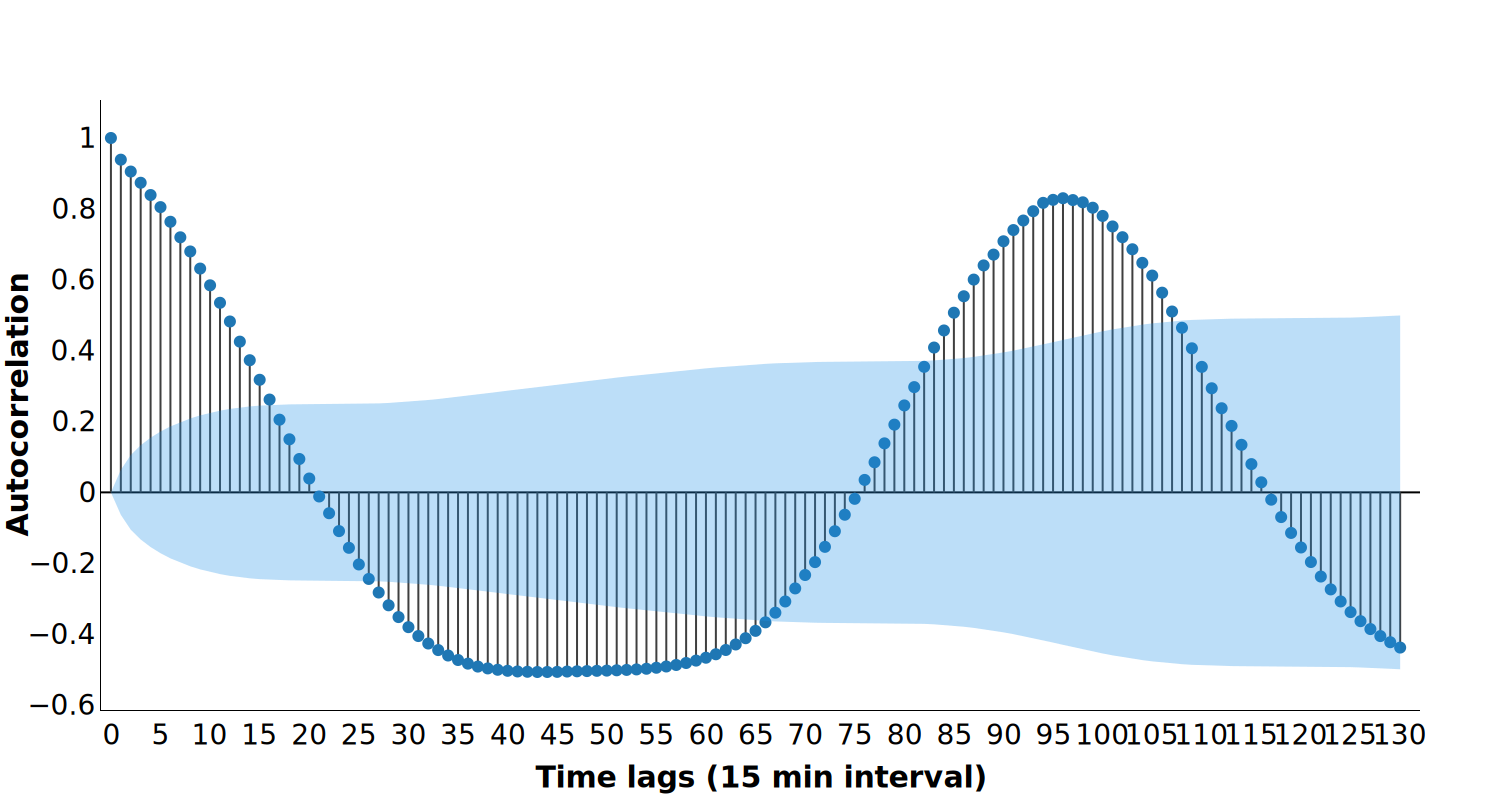

In [16]:
create_corr_plot(datosPV_test,False,130,0.01)

In [20]:
result = adfuller(datosPV_train, autolag='AIC',  regression="n")
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'n_lags: {result[2]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    if result[0] <= value:
      print("Strong evidence aganist Null Hypothesis. So, reject Null Hypothesis and conclude data is stationary.")
    else:
      print("Weak evidence aganist Null Hypothesis. So, accept Null Hypothesis and conclude data is non-stationary.")

ADF Statistic: -14.257496678581285
p-value: 1.1414118327871442e-25
n_lags: 25
Critial Values:
   1%, -2.5659338715503375
Strong evidence aganist Null Hypothesis. So, reject Null Hypothesis and conclude data is stationary.
Critial Values:
   5%, -1.9410233129453305
Strong evidence aganist Null Hypothesis. So, reject Null Hypothesis and conclude data is stationary.
Critial Values:
   10%, -1.6167969928137382
Strong evidence aganist Null Hypothesis. So, reject Null Hypothesis and conclude data is stationary.


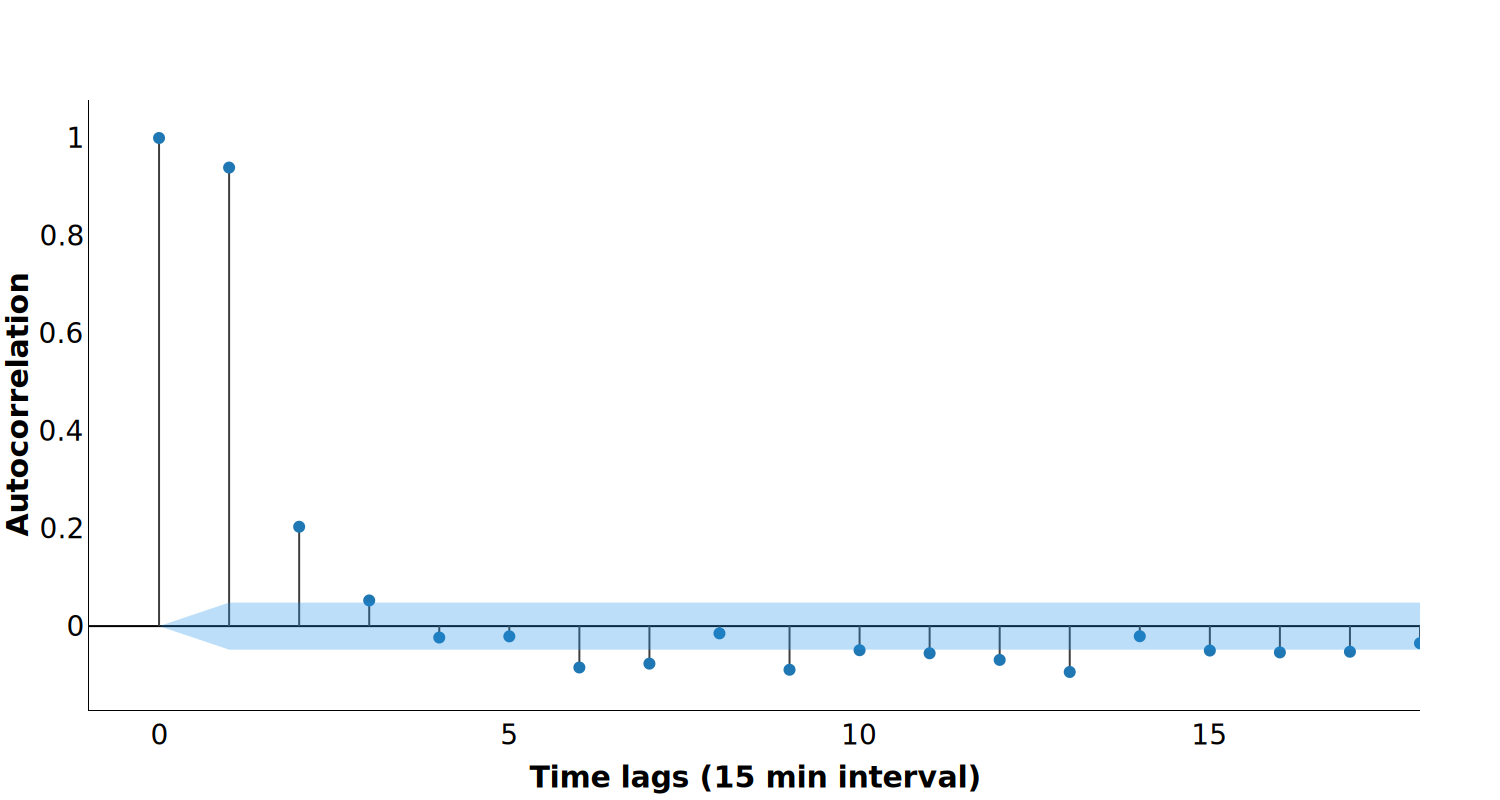

In [22]:
create_corr_plot(datosPV_test,True,16,0.05)

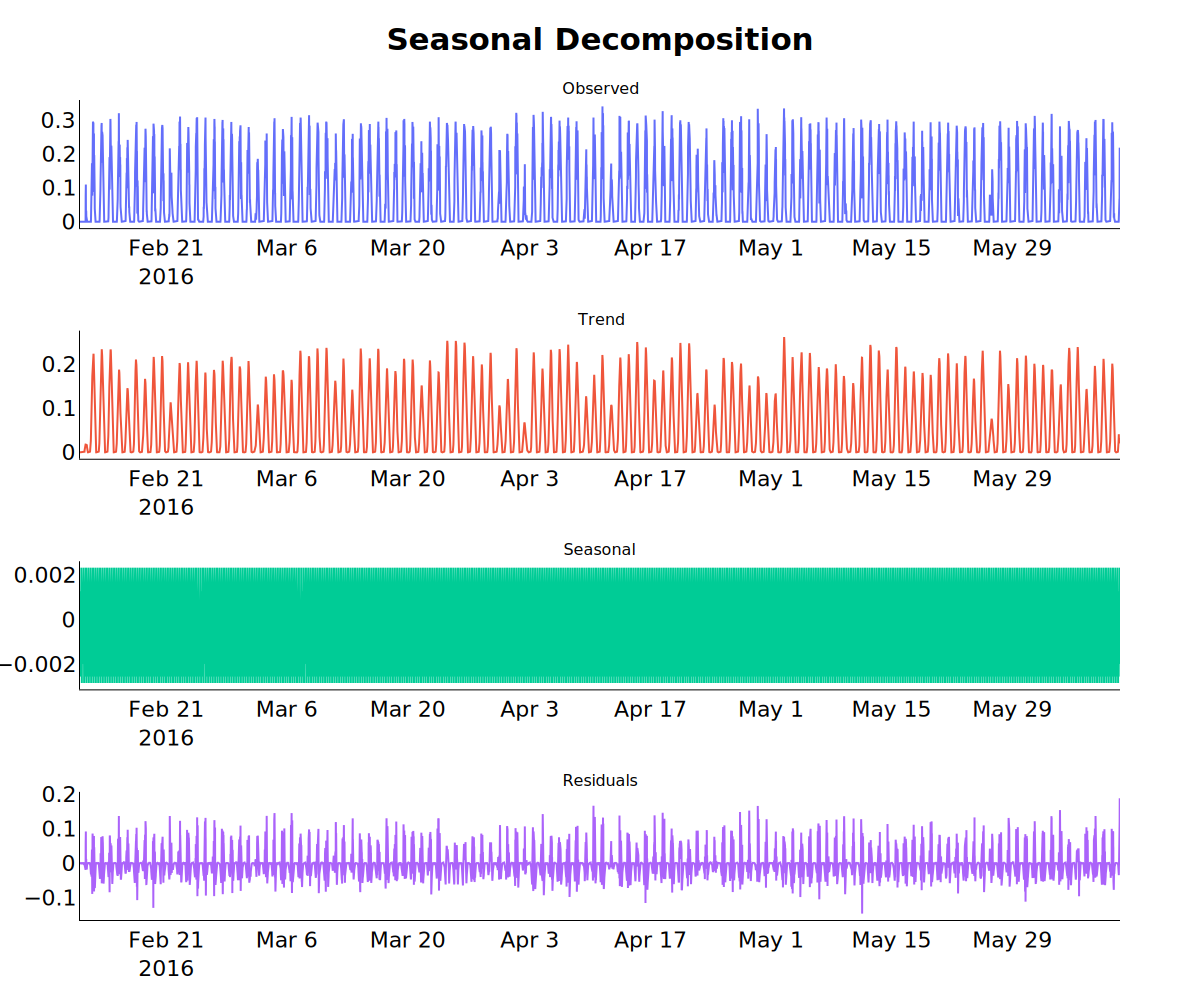

In [25]:
res = seasonal_decompose(x=datosPV_train, model='additive', period=26, extrapolate_trend='freq')

title:str="Seasonal Decomposition"
figPVm = make_subplots(rows=4, cols=1, subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],)
figPVm.append_trace(go.Scatter(x=res.observed.index, y=res.observed, mode="lines", name='Observed'),row=1,col=1)
figPVm.append_trace(go.Scatter(x=res.observed.index, y=res.trend, mode="lines", name='Trend'),row=2,col=1)
figPVm.append_trace(go.Scatter(x=res.observed.index, y=res.seasonal, mode="lines", name='Seasonal'),row=3,col=1)
figPVm.append_trace(go.Scatter(x=res.observed.index, y=res.resid, mode="lines", name='Residual'),row=4,col=1)
figPVm.update_layout(title=f'<b>{title}</b>',
                    margin={'t':100}, title_x=0.5,
                    #paper_bgcolor='rgba(0,0,0,0)',
                    plot_bgcolor='rgba(0,0,0,0)',
                    width=1200,height=1000,
                    yaxis=dict(color="black"),
                    xaxis=dict(color="black"),
                    font=dict(family="Fira Sans, Condensed", color='black', size=22),
                    showlegend=False)
figPVm.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=False)
figPVm.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=False)
figPVm.show("svg")